In [255]:
!ls ../../dsc-phase-2-project-v2-3/data/kc_house_data.csv

../../dsc-phase-2-project-v2-3/data/kc_house_data.csv


In [256]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as mae
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [456]:
def predictor(
    base_df,
    bedrooms=float(0),
    sqft_living=float(0),
    sqft_lot=float(0),
    floors=float(0),
    waterfront=float(0),
    view=float(0),
    condition=float(0),
    sqft_basement=float(0),
    yr_built=float(0),
    yr_renovated=float(0),
    zipcode=float(0),
    lat=float(0),
    long=float(0)
):
    pred_df = pd.DataFrame({
        'bedrooms': [bedrooms],
        'sqft_living': [sqft_living],
        'sqft_lot': [sqft_lot],
        'floors': [floors],
        'waterfront': [waterfront],
        'view': [view],
        'condition': [condition],
        'sqft_basement': [sqft_basement],
        'yr_built': [yr_built],
        'yr_renovated': [yr_renovated],
        'zipcode': [zipcode],
        'lat': [lat],
        'long':[long]
    })
    
    
    X = base_df.drop(columns=["price"])
    y = base_df["price"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)
    
    zip_train = X_train[["zipcode"]]
    zip_test = X_test[["zipcode"]]
    zip_pred = pred_df[["zipcode"]]
    ohe = OneHotEncoder(handle_unknown='ignore',
                        sparse=False,
                        categories='auto')
    ohe.fit(zip_train)
    
    zip_encoded_train = ohe.transform(zip_train)
    zip_encoded_test = ohe.transform(zip_test)
    zip_encoded_pred = ohe.transform(zip_pred)
    
    
    zip_encoded_train = pd.DataFrame(
    # Pass in NumPy array
        zip_encoded_train,
    # Set the column names to the categories found by OHE
        columns=ohe.categories_[0],
    # Set the index to match X_train's index
        index=X_train.index
    )

    zip_encoded_test = pd.DataFrame(
    # Pass in NumPy array
        zip_encoded_test,
    # Set the column names to the categories found by OHE
        columns=ohe.categories_[0],
    # Set the index to match X_train's index
        index=X_test.index
    )
    
    zip_encoded_pred = pd.DataFrame(
    # Pass in NumPy array
        zip_encoded_pred,
    # Set the column names to the categories found by OHE
        columns=ohe.categories_[0],
    # Set the index to match X_train's index
        index=pred_df.index
    )
    
    X_train.drop("zipcode", axis=1, inplace=True)

    X_train = pd.concat([X_train, zip_encoded_train], axis=1)


    X_test.drop("zipcode", axis=1, inplace=True)

    X_test = pd.concat([X_test, zip_encoded_test], axis=1)
    
    
    pred_df.drop("zipcode", axis=1, inplace=True)

    pred_df = pd.concat([pred_df, zip_encoded_pred], axis=1)
    
    
    lr_x = LinearRegression()

    lr_x.fit(X_train, y_train)
    
    
    print(f"Train R2: {lr_x.score(X_train, y_train):.4f}")
    print(f"Test R2: {lr_x.score(X_test, y_test):.4f}")
    y_pred = lr_x.predict(X_test)
    print(f"RMSE: ${mae(y_test, y_pred, squared = False)}")
    
    
    pred = lr_x.predict(sm.add_constant(pred_df))
    print(f"Predicted Price ${pred[0]:8f}")

In [257]:
def evaluate_model(X_tr, X_te, y_tr, y_te, log=False, constant=True):
    '''
    I EXPECT YOU TO WRITE A GOOD DOCSTRING HERE
    If you copy this word for word, and don't make it your own, please credit Lindsey
    '''
    if constant == True:
        model = sm.OLS(y_tr, sm.add_constant(X_tr)).fit()
        tr_preds = model.predict(sm.add_constant(X_tr))    
        te_preds = model.predict(sm.add_constant(X_te))
    # Create and fit model
    else:
        model = sm.OLS(y_tr, X_tr).fit()
        tr_preds = model.predict(X_tr)    
        te_preds = model.predict(X_te)
    # Print summary (if OLS)
    print(model.summary())
    
    # Grab predictions
    
    
    # Evaluate on train and test
    print("*"*20)
    print(f"Train R2 Score: {r2_score(y_tr, tr_preds):.4f}")
    if log == True:
        y_tr_unlog = np.expm1(y_tr)
        tr_preds_unlog = np.expm1(tr_preds)      
        print(f"Train MAE Score: ${mean_absolute_error(y_tr_unlog, tr_preds_unlog):.4f}")
        print(f"Train RMSE Score: ${mean_squared_error(y_tr_unlog, tr_preds_unlog, squared=False):.4f}")
    else:
        print(f"Train MAE Score: ${mean_absolute_error(y_tr, tr_preds):.4f}")
        print(f"Train RMSE Score: ${mean_squared_error(y_tr, tr_preds, squared=False):.4f}")
    print("*"*20)
    print(f"Test R2 Score: {r2_score(y_te, te_preds):.4f}")
    if log == True:
        y_te_unlog = np.expm1(y_te)
        te_preds_unlog = np.expm1(te_preds)
        print(f"Test MAE Score: ${mean_absolute_error(y_te_unlog, te_preds_unlog):.4f}")
        print(f"Test RMSE Score: ${mean_squared_error(y_te_unlog, te_preds_unlog, squared=False):.4f}")          
    else:
        print(f"Test MAE Score: ${mean_absolute_error(y_te, te_preds):.4f}")
        print(f"Test RMSE Score: ${mean_squared_error(y_te, te_preds, squared=False):.4f}")  
    print("*"*20)
    
    # Visualize residuals
    plt.scatter(tr_preds, y_tr-tr_preds, label='Train')
    plt.scatter(te_preds, y_te-te_preds, label='Test')

    plt.axhline(y=0, color = 'red', label = '0')
    plt.xlabel('predictions')
    plt.ylabel('residuals')
    plt.legend()
    plt.show()
    
    return tr_preds, te_preds

In [258]:
df = pd.read_csv("../../dsc-phase-2-project-v2-3/data/kc_house_data.csv", parse_dates=[1])
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [398]:
df_que3.describe()

,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
count,14359.000000,14359.000000,14359.000000,1.435900e+04,14359.000000,14359.000000,14359.000000,14359.000000,14359.000000,14359.000000,14359.000000,14359.000000,14359.000000,14359.000000
mean,468052.668779,3.317014,1956.623790,1.476112e+04,1.470959,0.002855,-1.842329,0.406714,261.644404,1970.889686,71.155025,98078.040114,47.554915,-122.212653
std,196562.825376,0.856583,750.827983,4.099013e+04,0.534920,0.053361,0.614461,0.646806,402.478549,29.024416,370.065282,53.263435,0.141886,0.142367
min,82000.000000,1.000000,370.000000,5.200000e+02,1.000000,0.000000,-2.000000,-2.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000
25%,313500.000000,3.000000,1400.000000,5.000000e+03,1.000000,0.000000,-2.000000,0.000000,0.000000,1952.000000,0.000000,98033.000000,47.456200,-122.330000
50%,435000.000000,3.000000,1850.000000,7.500000e+03,1.000000,0.000000,-2.000000,0.000000,0.000000,1975.000000,0.000000,98065.000000,47.565200,-122.230000
75%,590000.000000,4.000000,2410.000000,1.025200e+04,2.000000,0.000000,-2.000000,1.000000,500.000000,1996.000000,0.000000,98118.000000,47.679600,-122.121000
max,1000000.000000,6.000000,7120.000000,1.651359e+06,3.500000,1.000000,2.000000,2.000000,2720.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000


In [260]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     19221 non-null  object        
 9   view           21534 non-null  object        
 10  condition      21597 non-null  object        
 11  grade          21597 non-null  object        
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  object        
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   1775

In [261]:
df["zipcode"].value_counts()

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

In [262]:
df["waterfront"].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

In [263]:
df["view"].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [264]:
df["yr_renovated"].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [265]:
df["condition"].value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [266]:
df["grade"].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [267]:
df["sqft_basement"].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1990.0        1
2390.0        1
861.0         1
652.0         1
946.0         1
Name: sqft_basement, Length: 304, dtype: int64

In [268]:
map_cond = {
    "Poor" : -2,
    "Fair" : -1,
    "Average" : 0,
    "Good" : 1,
    "Very Good" : 2   
}

In [269]:
map_grade = {
    "3 Poor" : -4,
    "4 Low" : -3,
    "5 Fair" : -2,
    "6 Low Average" : -1,
    "7 Average" : 0,
    "8 Good" : 1,
    "9 Better" : 2,
    "10 Very Good" : 3,
    "11 Excellent" : 4,
    "12 Luxury" : 5,
    "13 Mansion" : 6
}

In [270]:
map_view = {
    "NONE" : -2,
    "FAIR" : -1,
    "AVERAGE" : 0,
    "GOOD" : 1,
    "EXCELLENT" : 2
}

In [271]:
map_water = {
    "NO" : 0,
    "YES" : 1
}

In [272]:
df["condition"] = df["condition"].map(map_cond)

In [273]:
df["grade"] = df["grade"].map(map_grade)

In [274]:
df["view"] = df["view"].map(map_view)

In [275]:
df["waterfront"] = df["waterfront"].map(map_water)

In [276]:
df = df.loc[(df["price"] <= 1000000) & (df["bedrooms"] <= 6)]

In [277]:
df_que = df.dropna()

In [278]:
df_que.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.467200e+04,14672.000000,14672.000000,14672.000000,14672.000000,1.467200e+04,14672.000000,14672.000000,14672.000000,14672.000000,14672.000000,14672.000000,14672.00000,14672.000000,14672.000000,14672.000000,14672.000000,14672.000000,14672.000000
mean,4.622641e+09,468171.367775,3.317612,2.040911,1956.200927,1.475352e+04,1.471647,0.002863,-1.841058,0.406284,0.511450,1694.536396,1970.89163,71.536464,98078.129362,47.554850,-122.212643,1911.677890,12524.952631
std,2.877190e+09,196430.122071,0.858940,0.695125,750.892418,4.081908e+04,0.535382,0.053428,0.616572,0.646880,1.012029,709.476821,29.06256,371.006388,53.225087,0.141735,0.142598,599.195667,27050.449114
min,1.000102e+06,82000.000000,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,-2.000000,-2.000000,-4.000000,370.000000,1900.00000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000
25%,2.155375e+09,314000.000000,3.000000,1.500000,1400.000000,5.000000e+03,1.000000,0.000000,-2.000000,0.000000,0.000000,1170.000000,1952.00000,0.000000,98033.000000,47.456400,-122.330000,1470.000000,5060.000000
50%,3.955900e+09,435000.000000,3.000000,2.000000,1850.000000,7.500000e+03,1.000000,0.000000,-2.000000,0.000000,0.000000,1510.000000,1975.00000,0.000000,98065.000000,47.565150,-122.231000,1800.000000,7532.000000
75%,7.349650e+09,592000.000000,4.000000,2.500000,2410.000000,1.025425e+04,2.000000,0.000000,-2.000000,1.000000,1.000000,2080.000000,1996.00000,0.000000,98118.000000,47.679500,-122.121000,2260.000000,9875.000000
max,9.895000e+09,1000000.000000,6.000000,6.000000,7120.000000,1.651359e+06,3.500000,1.000000,2.000000,2.000000,5.000000,5710.000000,2015.00000,2015.000000,98199.000000,47.777600,-121.315000,4950.000000,871200.000000


In [279]:
df_que = df_que.loc[df["sqft_basement"] != "?"]

In [280]:
df_que["sqft_basement"] = df_que["sqft_basement"].astype(float)

In [281]:
df_que = df_que.drop(columns=["date"])

<AxesSubplot:>

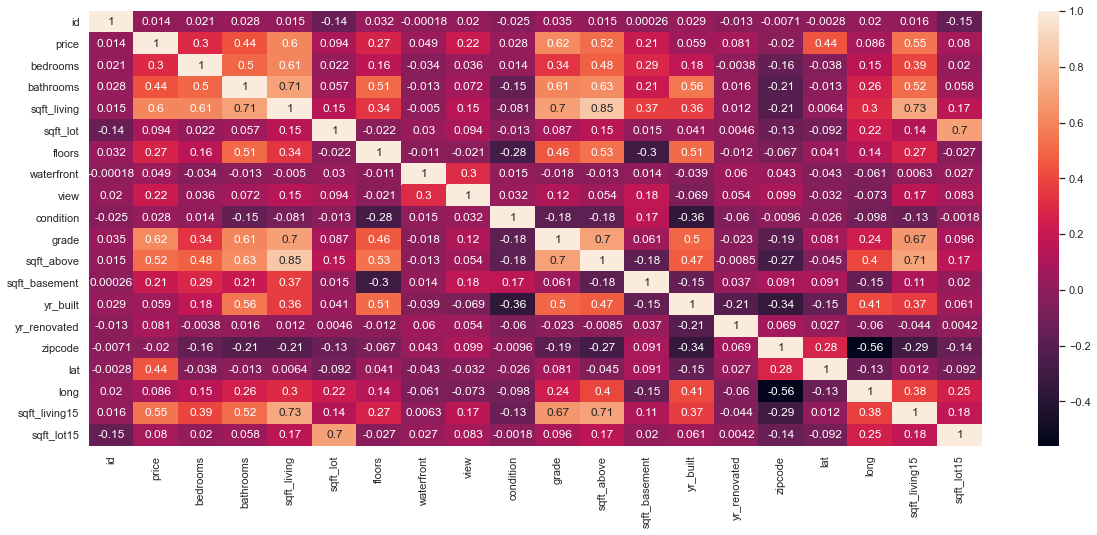

In [282]:
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(df_que.corr(), annot=True)

In [283]:
X = df_que["sqft_living"]
y = df_que["price"]

sqft_price = sm.OLS(y, sm.add_constant(X)).fit()

In [284]:
simple_model_summary = sqft_price.summary()
simple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     8282.
Date:                Wed, 29 Jun 2022   Prob (F-statistic):               0.00
Time:                        10:13:58   Log-Likelihood:            -1.9212e+05
No. Observations:               14359   AIC:                         3.842e+05
Df Residuals:                   14357   BIC:                         3.843e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.582e+05   3646.387     43.393      0.000    1.51e+05    1.65e+05
sqft_living   158.3463      1.740     91.008      0.000     154.936     161.757
==============================================================================
Omnibus:                      484.779   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              534.420
Skew:                           0.471   Prob(JB):                    8.96e-117
Kurtosis:                       2.929   Cond. No.                     5.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Just everything

In [285]:
X1 = df_que.drop(columns=["price"])
y = df_que["price"]

all_price = sm.OLS(y, sm.add_constant(X1)).fit()

In [286]:
simple_model_summary = all_price.summary()
simple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     1783.
Date:                Wed, 29 Jun 2022   Prob (F-statistic):               0.00
Time:                        10:13:58   Log-Likelihood:            -1.8696e+05
No. Observations:               14359   AIC:                         3.739e+05
Df Residuals:                   14340   BIC:                         3.741e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -5.59e+06   1.96e+06     -2.852      0.004   -9.43e+06   -1.75e+06
id             3.356e-07   3.22e-07      1.042      0.298   -2.96e-07    9.67e-07
bedrooms      -9913.4803   1398.258     -7.090      0.000   -1.27e+04   -7172.713
bathrooms      2.246e+04   2273.281      9.880      0.000     1.8e+04    2.69e+04
sqft_living      45.8968      1.703     26.954      0.000      42.559      49.235
sqft_lot          0.2367      0.031      7.540      0.000       0.175       0.298
floors         3.175e+04   2465.017     12.879      0.000    2.69e+04    3.66e+04
waterfront     1.225e+05    1.8e+04      6.796      0.000    8.72e+04    1.58e+05
view           2.913e+04   1644.556     17.713      0.000    2.59e+04    3.24e+04
condition      2.554e+04   1573.210     16.236      0.000    2.25e+04    2.86e+04
grade          6.934e+04   1503.334     46.123      0.000    6.64e+04    7.23e+04
sqft_above       24.4415      1.654     14.774      0.000      21.199      27.684
sqft_basement    21.4553      1.905     11.262      0.000      17.721      25.190
yr_built      -1732.7728     49.939    -34.698      0.000   -1830.661   -1634.885
yr_renovated     14.9003      2.612      5.704      0.000       9.780      20.021
zipcode        -206.6070     22.042     -9.373      0.000    -249.813    -163.401
lat            5.417e+05   7002.692     77.355      0.000    5.28e+05    5.55e+05
long          -3.024e+04   8700.334     -3.475      0.001   -4.73e+04   -1.32e+04
sqft_living15    46.0058      2.537     18.132      0.000      41.033      50.979
sqft_lot15       -0.1327      0.048     -2.738      0.006      -0.228      -0.038
==============================================================================
Omnibus:                      720.261   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1119.330
Skew:                           0.438   Prob(JB):                    8.72e-244
Kurtosis:                       4.050   Cond. No.                     3.09e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.46e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Dropping based on heatmap

In [287]:
X2 = df_que.drop(columns=["price", "grade", "sqft_above", "sqft_living15", "bathrooms", "sqft_lot15"])
y = df_que["price"]

all_price_1 = sm.OLS(y, sm.add_constant(X2)).fit()

In [288]:
simple_model_summary = all_price_1.summary()
simple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     1670.
Date:                Wed, 29 Jun 2022   Prob (F-statistic):               0.00
Time:                        10:13:58   Log-Likelihood:            -1.8845e+05
No. Observations:               14359   AIC:                         3.769e+05
Df Residuals:                   14344   BIC:                         3.770e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.018e+06   2.14e+06     -1.881      0.060   -8.21e+06    1.68e+05
id             8.543e-07   3.56e-07      2.399      0.016    1.56e-07    1.55e-06
bedrooms      -1.702e+04   1511.487    -11.260      0.000      -2e+04   -1.41e+04
sqft_living     172.6668      2.154     80.162      0.000     168.445     176.889
sqft_lot          0.1621      0.026      6.202      0.000       0.111       0.213
floors         4.251e+04   2586.424     16.437      0.000    3.74e+04    4.76e+04
waterfront     8.468e+04      2e+04      4.237      0.000    4.55e+04    1.24e+05
view           4.209e+04   1796.783     23.427      0.000    3.86e+04    4.56e+04
condition       2.57e+04   1736.491     14.802      0.000    2.23e+04    2.91e+04
sqft_basement   -35.8268      3.310    -10.824      0.000     -42.315     -29.339
yr_built       -888.6512     49.870    -17.819      0.000    -986.404    -790.899
yr_renovated     19.7288      2.864      6.889      0.000      14.116      25.342
zipcode        -322.6652     24.289    -13.284      0.000    -370.275    -275.055
lat            6.191e+05   7622.169     81.229      0.000    6.04e+05    6.34e+05
long          -6.681e+04   9439.634     -7.078      0.000   -8.53e+04   -4.83e+04
==============================================================================
Omnibus:                      589.130   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              820.328
Skew:                           0.410   Prob(JB):                    7.38e-179
Kurtosis:                       3.835   Cond. No.                     1.15e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Dropping based on p(statistic) and heatmap

In [289]:
X3 = df_que.drop(columns=["price", "grade", "sqft_above", "sqft_living15", "bathrooms", "sqft_lot15", "id"])
y = df_que["price"]

all_price_2 = sm.OLS(y, X3).fit()

In [290]:
simple_model_summary = all_price_2.summary()
simple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.943
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                          1.825e+04
Date:                Wed, 29 Jun 2022   Prob (F-statistic):                        0.00
Time:                        10:13:58   Log-Likelihood:                     -1.8845e+05
No. Observations:               14359   AIC:                                  3.769e+05
Df Residuals:                   14346   BIC:                                  3.770e+05
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -1.714e+04   1509.748    -11.353      0.000   -2.01e+04   -1.42e+04
sqft_living     172.1095      2.132     80.712      0.000     167.930     176.289
sqft_lot          0.1481      0.026      5.756      0.000       0.098       0.199
floors         4.361e+04   2528.147     17.250      0.000    3.87e+04    4.86e+04
waterfront     8.489e+04      2e+04      4.247      0.000    4.57e+04    1.24e+05
view           4.253e+04   1789.176     23.771      0.000     3.9e+04     4.6e+04
condition      2.513e+04   1716.129     14.645      0.000    2.18e+04    2.85e+04
sqft_basement   -34.6601      3.256    -10.646      0.000     -41.042     -28.278
yr_built       -922.2089     46.506    -19.830      0.000   -1013.366    -831.052
yr_renovated     19.3967      2.861      6.780      0.000      13.789      25.005
zipcode        -360.2695     12.790    -28.169      0.000    -385.339    -335.200
lat            6.194e+05   7619.573     81.287      0.000    6.04e+05    6.34e+05
long           -6.46e+04   9407.919     -6.867      0.000    -8.3e+04   -4.62e+04
==============================================================================
Omnibus:                      578.838   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              803.336
Skew:                           0.406   Prob(JB):                    3.61e-175
Kurtosis:                       3.826   Cond. No.                     1.97e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.97e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [291]:
# sns.pairplot(df_que.drop(columns=["grade", "sqft_above", "sqft_living15", "bathrooms", "sqft_lot15", "id"]))

In [292]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [293]:
lr_x1 = LinearRegression()

lr_x1.fit(X_train1, y_train1)

print(f"Train R2: {lr_x1.score(X_train1, y_train1):.4f}")
print(f"Test R2: {lr_x1.score(X_test1, y_test1):.4f}")

Train R2: 0.6925
Test R2: 0.6860


In [294]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [295]:
lr_x2 = LinearRegression()

lr_x2.fit(X_train2, y_train2)

print(f"Train R2: {lr_x2.score(X_train2, y_train2):.4f}")
print(f"Test R2: {lr_x2.score(X_test2, y_test2):.4f}")

Train R2: 0.6204
Test R2: 0.6170


In [296]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [297]:
lr_x3 = LinearRegression(fit_intercept=False)

lr_x3.fit(X_train3, y_train3)

print(f"Train R2: {lr_x3.score(X_train3, y_train3):.4f}")
print(f"Test R2: {lr_x3.score(X_test3, y_test3):.4f}")
reg = LinearRegression().fit(X_train3, y_train3)
print(f"R-Squares: {reg.score(X3, y)}%")
y_pred3 = reg.predict(X_test3)
print(f"RMSE: ${mae(y_test3, y_pred3, squared = False)}")
print(lr_x3.intercept_, lr_x3.coef_)

Train R2: 0.6202
Test R2: 0.6166
R-Squares: 0.6194657158694916%
RMSE: $118896.78005638943
0.0 [-1.90868757e+04  1.76318358e+02  1.42959122e-01  4.08024035e+04
  7.79707057e+04  4.09001012e+04  2.59346377e+04 -3.78501949e+01
 -8.88937524e+02  2.08018539e+01 -3.68389419e+02  6.14783982e+05
 -7.23728253e+04]


In [298]:
# dict(df_que["zipcode"].value_counts()).keys()

In [299]:
df_pr_zip = df_que.drop(columns=["id", "bedrooms", "bathrooms", "sqft_living", "sqft_lot", "waterfront", "view", "condition", "grade", "sqft_above", "sqft_basement", "yr_built", "yr_renovated", "lat", "long", "sqft_living15", "sqft_lot15", "floors"]).groupby(df_que["zipcode"]).mean().head(71)

In [300]:
df_pr_zip = df_pr_zip.sort_values(by=['price'],ascending=True).drop(columns=["zipcode"])

In [301]:
df_pr_zip = df_pr_zip.reset_index().drop(columns=["price"])

In [302]:
map_zip = dict(dict(df_pr_zip)["zipcode"])

In [303]:
map_zip = {str(y):str(x) for x,y in map_zip.items()}

In [304]:
# map_zip

In [305]:
# df_que

In [306]:
df_que1 = df_que.copy()

In [307]:
df_que1["zipcode"] = df_que1["zipcode"].astype(str)

In [308]:
df_que1["zipcode"]

1        98125
3        98136
4        98074
8        98146
9        98038
         ...  
21591    98116
21592    98103
21593    98146
21594    98144
21596    98144
Name: zipcode, Length: 14359, dtype: object

In [309]:
df_que1["zipcode"] = df_que1["zipcode"].map(map_zip)

In [310]:
df_que1["zipcode"] = df_que1["zipcode"].astype(int)

In [311]:
# sns.set(rc = {'figure.figsize':(20,8)})
# sns.heatmap(df_que1.corr(), annot=True)

In [312]:
X4 = df_que1.drop(columns=["price", "grade", "sqft_above", "sqft_living15", "bathrooms", "sqft_lot15", "id"])
y1 = df_que1["price"]

all_price_4 = sm.OLS(y, X4).fit()

In [313]:
simple_model_summary = all_price_4.summary()
simple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                          3.005e+04
Date:                Wed, 29 Jun 2022   Prob (F-statistic):                        0.00
Time:                        10:13:59   Log-Likelihood:                     -1.8503e+05
No. Observations:               14359   AIC:                                  3.701e+05
Df Residuals:                   14346   BIC:                                  3.702e+05
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -8513.7475   1193.038     -7.136      0.000   -1.09e+04   -6175.239
sqft_living     144.3271      1.672     86.318      0.000     141.050     147.605
sqft_lot          0.1198      0.020      5.984      0.000       0.081       0.159
floors         2.505e+04   1985.468     12.619      0.000    2.12e+04    2.89e+04
waterfront     7.598e+04   1.58e+04      4.824      0.000    4.51e+04    1.07e+05
view           3.907e+04   1410.396     27.701      0.000    3.63e+04    4.18e+04
condition      1.454e+04   1355.205     10.727      0.000    1.19e+04    1.72e+04
sqft_basement   -25.5842      2.511    -10.189      0.000     -30.506     -20.662
yr_built       -852.3467     35.224    -24.198      0.000    -921.391    -783.303
yr_renovated     11.4198      2.252      5.070      0.000       7.005      15.835
zipcode        6051.7592     60.435    100.136      0.000    5933.298    6170.220
lat            2.202e+04   7621.507      2.889      0.004    7078.690     3.7e+04
long          -5571.6028   2986.065     -1.866      0.062   -1.14e+04     281.471
==============================================================================
Omnibus:                      826.126   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1853.621
Skew:                           0.374   Prob(JB):                         0.00
Kurtosis:                       4.593   Cond. No.                     8.61e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [314]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y1, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [315]:
lr_x4 = LinearRegression()

lr_x4.fit(X_train4, y_train4)

print(f"Train R2: {lr_x4.score(X_train4, y_train4):.4f}")
print(f"Test R2: {lr_x4.score(X_test4, y_test4):.4f}")

Train R2: 0.7838
Test R2: 0.7766


In [316]:
# sns.pairplot(df_que1.drop(columns=["grade", "sqft_above", "sqft_living15", "bathrooms", "sqft_lot15", "id"]), kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})

In [317]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X3, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [318]:
zip_train = X_train5[["zipcode"]]
zip_test = X_test5[["zipcode"]]
ohe = OneHotEncoder(handle_unknown='ignore',
                        sparse=False,
                        categories='auto')

ohe.fit(zip_train)


OneHotEncoder(handle_unknown='ignore', sparse=False)

In [319]:
zip_encoded_train = ohe.transform(zip_train)
zip_encoded_test = ohe.transform(zip_test)

In [320]:
zip_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    zip_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=X_train5.index
)


In [321]:
zip_encoded_test = pd.DataFrame(
    # Pass in NumPy array
    zip_encoded_test,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=X_test5.index
)

In [322]:
X_train5.drop("zipcode", axis=1, inplace=True)

X_train5 = pd.concat([X_train5, zip_encoded_train], axis=1)


X_test5.drop("zipcode", axis=1, inplace=True)

X_test5 = pd.concat([X_test5, zip_encoded_test], axis=1)


C:\Users\AsuS\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [323]:
lr_x5 = LinearRegression()

lr_x5.fit(X_train5, y_train5)

print(f"Train R2: {lr_x5.score(X_train5, y_train5):.4f}")
print(f"Test R2: {lr_x5.score(X_test5, y_test5):.4f}")

Train R2: 0.8092
Test R2: 0.8008


In [345]:
all_price_5 = sm.OLS(y_train5, X_train5).fit()

In [346]:
simple_model_summary = all_price_5.summary()
simple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     559.7
Date:                Wed, 29 Jun 2022   Prob (F-statistic):               0.00
Time:                        10:44:37   Log-Likelihood:            -1.3770e+05
No. Observations:               10769   AIC:                         2.756e+05
Df Residuals:                   10687   BIC:                         2.762e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -8312.0240   1274.950     -6.519      0.000   -1.08e+04   -5812.885
sqft_living     172.8399      1.874     92.232      0.000     169.167     176.513
sqft_lot          0.2952      0.022     13.597      0.000       0.253       0.338
floors        -1.604e+04   2413.688     -6.643      0.000   -2.08e+04   -1.13e+04
waterfront     1.207e+05   1.74e+04      6.941      0.000    8.66e+04    1.55e+05
view           3.568e+04   1523.192     23.422      0.000    3.27e+04    3.87e+04
condition      2.224e+04   1473.459     15.096      0.000    1.94e+04    2.51e+04
sqft_basement   -69.8881      2.881    -24.256      0.000     -75.536     -64.240
yr_built        141.8065     45.038      3.149      0.002      53.523     230.090
yr_renovated     20.2270      2.349      8.610      0.000      15.622      24.832
lat            2.167e+05   4.83e+04      4.484      0.000    1.22e+05    3.11e+05
long          -1.233e+05   3.39e+04     -3.634      0.000    -1.9e+05   -5.68e+04
98001         -2.553e+07   4.62e+06     -5.522      0.000   -3.46e+07   -1.65e+07
98002         -2.553e+07   4.62e+06     -5.524      0.000   -3.46e+07   -1.65e+07
98003         -2.553e+07   4.63e+06     -5.521      0.000   -3.46e+07   -1.65e+07
98004         -2.506e+07   4.63e+06     -5.414      0.000   -3.41e+07    -1.6e+07
98005          -2.52e+07   4.63e+06     -5.447      0.000   -3.43e+07   -1.61e+07
98006         -2.527e+07   4.63e+06     -5.462      0.000   -3.43e+07   -1.62e+07
98007         -2.529e+07   4.63e+06     -5.466      0.000   -3.44e+07   -1.62e+07
98008         -2.532e+07   4.63e+06     -5.473      0.000   -3.44e+07   -1.62e+07
98010         -2.542e+07   4.62e+06     -5.507      0.000   -3.45e+07   -1.64e+07
98011         -2.546e+07   4.63e+06     -5.497      0.000   -3.45e+07   -1.64e+07
98014         -2.545e+07   4.62e+06     -5.510      0.000   -3.45e+07   -1.64e+07
98019         -2.549e+07   4.62e+06     -5.514      0.000   -3.46e+07   -1.64e+07
98022         -2.548e+07   4.61e+06     -5.522      0.000   -3.45e+07   -1.64e+07
98023         -2.555e+07   4.63e+06     -5.522      0.000   -3.46e+07   -1.65e+07
98024         -2.538e+07   4.62e+06     -5.496      0.000   -3.44e+07   -1.63e+07
98027         -2.534e+07   4.62e+06     -5.483      0.000   -3.44e+07   -1.63e+07
98028         -2.548e+07   4.63e+06     -5.500      0.000   -3.46e+07   -1.64e+07
98029         -2.529e+07   4.62e+06     -5.472      0.000   -3.43e+07   -1.62e+07
98030         -2.552e+07   4.62e+06     -5.521      0.000   -3.46e+07   -1.65e+07
98031         -2.552e+07   4.62e+06     -5.519      0.000   -3.46e+07   -1.65e+07
98032         -2.554e+07   4.63e+06     -5.522      0.000   -3.46e+07   -1.65e+07
98033         -2.526e+07   4.63e+06     -5.457      0.000   -3.43e+07   -1.62e+07
98034         -2.541e+07   4.63e+06     -5.486   

In [326]:
X_train6, X_test6, y_train6, y_test6 = train_test_split(X3, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [327]:
Xy_train6 = pd.concat([X_train6, y_train6], axis=1)

Xy_train6_zip = Xy_train6.drop(columns=["zipcode", "bedrooms", "sqft_living", "sqft_lot", "waterfront", "view", "condition", "sqft_basement", "yr_built", "yr_renovated", "lat", "long", "floors"]).groupby(df_que["zipcode"]).mean().head(71)
Xy_train6_zip = Xy_train6_zip.sort_values(by=['price'],ascending=True).reset_index()
Xy_train6_zip = Xy_train6_zip.drop(columns=["price"])
map_zip1 = dict(dict(Xy_train6_zip)["zipcode"])
map_zip1 = {str(y):str(x) for x,y in map_zip1.items()}


In [328]:
# map_zip1

In [329]:
X_train6["zipcode"] = X_train6["zipcode"].astype(str)
X_train6["zipcode"] = X_train6["zipcode"].map(map_zip1)
X_train6["zipcode"] = X_train6["zipcode"].astype(int)

<ipython-input-329-3cef8f5147e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train6["zipcode"] = X_train6["zipcode"].astype(str)
<ipython-input-329-3cef8f5147e4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train6["zipcode"] = X_train6["zipcode"].map(map_zip1)
<ipython-input-329-3cef8f5147e4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [330]:
X_test6["zipcode"] = X_test6["zipcode"].astype(str)
X_test6["zipcode"] = X_test6["zipcode"].map(map_zip1)
X_test6["zipcode"] = X_test6["zipcode"].astype(int)

<ipython-input-330-b981ac6cb024>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test6["zipcode"] = X_test6["zipcode"].astype(str)
<ipython-input-330-b981ac6cb024>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test6["zipcode"] = X_test6["zipcode"].map(map_zip1)
<ipython-input-330-b981ac6cb024>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [360]:
pred_df = pd.

In [359]:
pred_df["bedrooms"] = 0

TypeError: 'module' object does not support item assignment

In [331]:
all_price_6 = sm.OLS(y_train6, X_train6).fit()
simple_model_summary = all_price_6.summary()
simple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.964
Method:                 Least Squares   F-statistic:                          2.248e+04
Date:                Wed, 29 Jun 2022   Prob (F-statistic):                        0.00
Time:                        10:13:59   Log-Likelihood:                     -1.3882e+05
No. Observations:               10769   AIC:                                  2.777e+05
Df Residuals:                   10756   BIC:                                  2.778e+05
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -8853.8473   1386.274     -6.387      0.000   -1.16e+04   -6136.495
sqft_living     145.4203      1.933     75.222      0.000     141.631     149.210
sqft_lot          0.1126      0.022      5.073      0.000       0.069       0.156
floors         2.282e+04   2305.633      9.896      0.000    1.83e+04    2.73e+04
waterfront     6.549e+04   1.84e+04      3.556      0.000    2.94e+04    1.02e+05
view            3.78e+04   1648.443     22.929      0.000    3.46e+04     4.1e+04
condition      1.458e+04   1573.090      9.266      0.000    1.15e+04    1.77e+04
sqft_basement   -26.2818      2.909     -9.034      0.000     -31.984     -20.579
yr_built       -841.8329     40.877    -20.594      0.000    -921.960    -761.706
yr_renovated     12.1583      2.572      4.728      0.000       7.117      17.199
zipcode        6114.9404     69.935     87.438      0.000    5977.856    6252.025
lat             3.02e+04   8703.227      3.470      0.001    1.31e+04    4.73e+04
long          -2210.4211   3416.580     -0.647      0.518   -8907.548    4486.706
==============================================================================
Omnibus:                      646.578   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1395.412
Skew:                           0.401   Prob(JB):                    9.78e-304
Kurtosis:                       4.570   Cond. No.                     9.04e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 9.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [332]:
lr_x6 = LinearRegression(fit_intercept=False)

lr_x6.fit(X_train6, y_train6)

print(f"Train R2: {lr_x6.score(X_train6, y_train6):.4f}")
print(f"Test R2: {lr_x6.score(X_test6, y_test6):.4f}")
print(f"R-Squares: {reg.score(X_test6, y_test6)}%")
y_pred6 = reg.predict(X_test6)
print(f"RMSE: ${mae(y_test6, y_pred6, squared = False)}")
print(lr_x6.intercept_, lr_x6.coef_)

Train R2: 0.7652
Test R2: 0.7564
R-Squares: -30086.12213036146%
RMSE: $33313894.90575158
0.0 [-8.85384730e+03  1.45420266e+02  1.12625183e-01  2.28171772e+04
  6.54894540e+04  3.77978965e+04  1.45758979e+04 -2.62817748e+01
 -8.41832937e+02  1.21582825e+01  6.11494036e+03  3.01970522e+04
 -2.21042110e+03]


In [335]:
y_train6.describe()

count      10769.000000
mean      469211.895162
std       198027.981923
min        82000.000000
25%       314000.000000
50%       435000.000000
75%       592000.000000
max      1000000.000000
Name: price, dtype: float64

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     2988.
Date:                Wed, 29 Jun 2022   Prob (F-statistic):               0.00
Time:                        10:13:59   Log-Likelihood:            -1.3839e+05
No. Observations:               10769   AIC:                         2.768e+05
Df Residuals:                   10755   BIC:                         2.769e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.925e+07   9.81e+05    -29.807

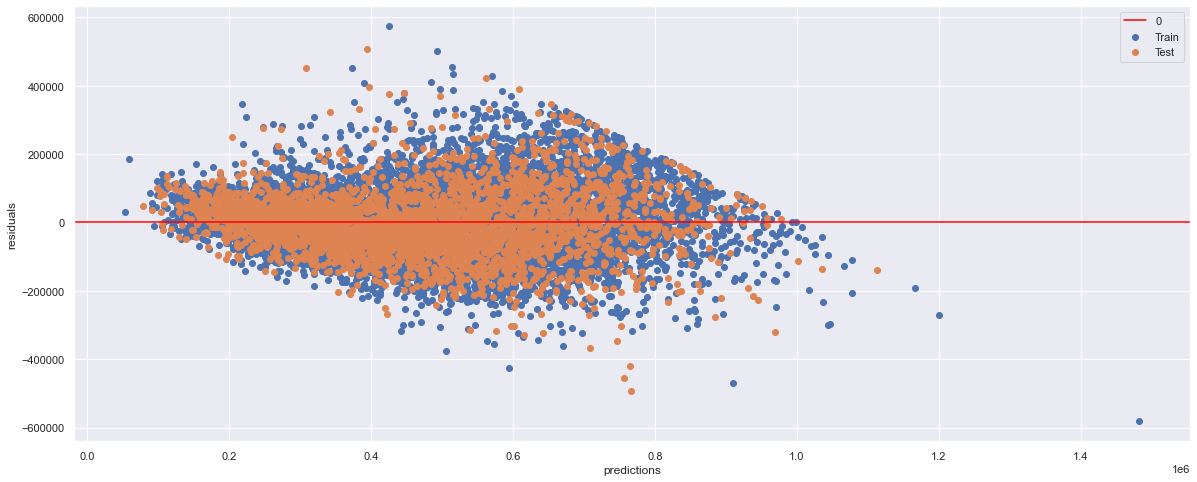

(864      344926.081304
 19416    531423.780911
 2249     308602.073315
 10263    292733.178704
 19271    674524.695881
              ...      
 7769     282662.994257
 20105    589366.464153
 8071     525533.238035
 1251     581437.602333
 10855    673885.652581
 Length: 10769, dtype: float64,
 10245    516456.553326
 6706     181113.163233
 21119    415832.116282
 14149    251656.145518
 5593     252637.628422
              ...      
 13678    506032.281872
 16393    311181.114010
 3290     214626.145296
 6224     281698.663390
 5252     656473.802358
 Length: 3590, dtype: float64)

In [333]:
evaluate_model(X_train6, X_test6, y_train6, y_test6)

In [347]:
ss5 = StandardScaler()
ss5.fit(X_train5)
X_train5_ss = ss5.transform(X_train5)
X_test5_ss = ss5.transform(X_test5)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     559.7
Date:                Wed, 29 Jun 2022   Prob (F-statistic):               0.00
Time:                        11:02:52   Log-Likelihood:            -1.3770e+05
No. Observations:               10769   AIC:                         2.756e+05
Df Residuals:                   10687   BIC:                         2.762e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.692e+05    836.626    560.838      0.0

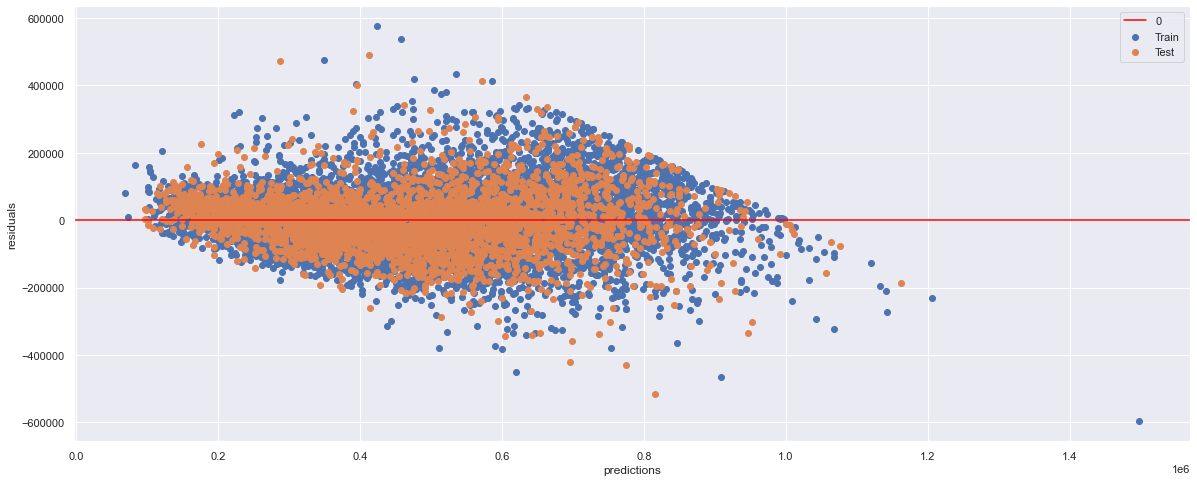

(array([288468.50965233, 541037.22426728, 332743.11698571, ...,
        447428.079956  , 564744.97988992, 705937.62111995]),
 array([539338.58835282, 207003.11046417, 424935.93679063, ...,
        240043.70029923, 280062.75796996, 684466.36524404]))

In [353]:
evaluate_model(X_train5_ss, X_test5_ss, y_train5, y_test5)

In [349]:
ss6 = StandardScaler()
ss6.fit(X_train6)
X_train6_ss = ss6.transform(X_train6)
X_test6_ss = ss6.transform(X_test6)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     2988.
Date:                Wed, 29 Jun 2022   Prob (F-statistic):               0.00
Time:                        11:03:19   Log-Likelihood:            -1.3839e+05
No. Observations:               10769   AIC:                         2.768e+05
Df Residuals:                   10755   BIC:                         2.769e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.692e+05    889.181    527.690      0.0

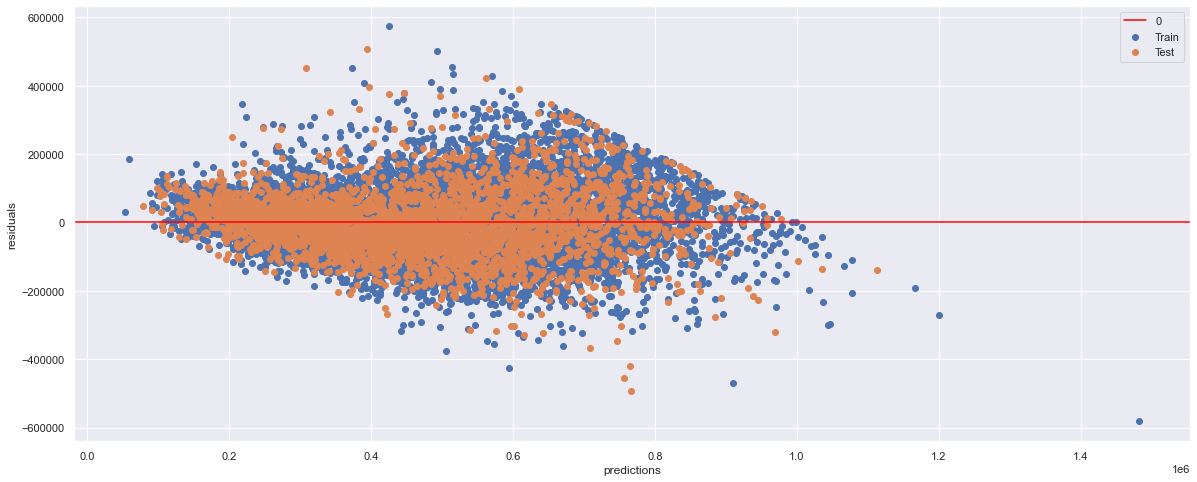

(array([344926.08130413, 531423.78091092, 308602.07331534, ...,
        525533.23803547, 581437.6023331 , 673885.65258125]),
 array([516456.55332622, 181113.16323265, 415832.11628217, ...,
        214626.14529638, 281698.66338966, 656473.8023583 ]))

In [355]:
evaluate_model(X_train6_ss, X_test6_ss, y_train6, y_test6)

In [363]:
df_que3 = df_que.drop(columns=["grade", "sqft_above", "sqft_living15", "bathrooms", "sqft_lot15", "id"])

In [476]:
predictor(
    base_df=df_que3, 
    bedrooms=2, 
    sqft_living=975, 
    sqft_lot=1021, 
    floors=1, 
    waterfront=1, 
    condition=2, 
    sqft_basement=0, 
    yr_built=1961, 
    lat=47.638310, 
    long=-122.276350, 
    zipcode=98112
)

Train R2: 0.8092
Test R2: 0.8008
RMSE: $85718.61618795569
Predicted Price $823645.104560


C:\Users\AsuS\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
